# Lab6.4-Topic-classification-BERT

Copyright: Vrije Universiteit Amsterdam, Faculty of Humanities, CLTL

In this notebook, we demonstrate how to fine-tune BERT for topic classification.

We will use the [simpletransformers library](https://simpletransformers.ai/):
 wrapper for the [huggingface transformers library](https://huggingface.co/) on PyTorch.

We are going to run the notebook on [colab](https://colab.research.google.com/?utm_source=scs-index), which has (limited) free access to GPUs.

You need to enable GPUs for the notebook:

* navigate to Edit → Notebook Settings
* select GPU from the Hardware Accelerator drop-down



### Install/import libraries

Install the simpletransformers library (restart your runtime after the installation)

In [2]:
!pip install simpletransformers --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 409.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.3/316.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.8 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=81c98401a5baf1c4b64027a4f6a3f00971d672fb2a0d2dd9ce39c9179616ecad
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [3]:
# Import libraries
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import classification_report
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import matplotlib.pyplot as plt
import seaborn as sn

Import [the 20 newsgroups text dataset](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html).

The dataset contains around 18,000 newsgroups posts on 20 topics.

In [4]:
from sklearn.datasets import fetch_20newsgroups

# load only a sub-selection of the categories (4 in our case)
categories = ['alt.atheism', 'comp.graphics', 'sci.med', 'sci.space']

# remove the headers, footers and quotes (to avoid overfitting)
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=categories, random_state=42)
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), categories=categories, random_state=42)

### Data exploration

The target attribute is the integer index of the category:

In [5]:
from collections import Counter
Counter(newsgroups_train.target)

Counter({np.int64(3): 593,
         np.int64(1): 584,
         np.int64(2): 594,
         np.int64(0): 480})

In [6]:
Counter(newsgroups_test.target)

Counter({np.int64(1): 389,
         np.int64(2): 396,
         np.int64(0): 319,
         np.int64(3): 394})

Convert data to pandas dataframe

In [7]:
train = pd.DataFrame({'text': newsgroups_train.data, 'labels': newsgroups_train.target})

In [8]:
print(len(train))
train.head(5)

2251


,text,labels
0,WHile we are on the subject of the shuttle sof...,3
1,There is a program called Graphic Workshop you...,1
2,,2
3,My girlfriend is in pain from kidney stones. S...,2
4,I think that's the correct spelling..\n\tI am ...,2


In [9]:
test = pd.DataFrame({'text': newsgroups_test.data, 'labels': newsgroups_test.target})

In [10]:
print(len(test))
test.head(5)

1498


,text,labels
0,\nAnd guess who's here in your place.\n\nPleas...,1
1,Does anyone know if any of Currier and Ives et...,1
2,=FLAME ON\n=\n=Reading through the posts about...,2
3,\nBut in this case I said I hoped that BCCI wa...,0
4,\nIn the kind I have made I used a Lite sour c...,2


Use a subset (10%) of the training set as a validation set

In [11]:
from sklearn.model_selection import train_test_split

train, dev = train_test_split(train, test_size=0.1, random_state=0,
                               stratify=train[['labels']])

In [12]:
print(len(train))
print("train:", train[['labels']].value_counts(sort=False))
train.head(3)

2025
train: labels
0         432
1         525
2         534
3         534
Name: count, dtype: int64


,text,labels
559,I wonder how many atheists out there care to s...,0
2060,We are interested in purchasing a grayscale pr...,1
1206,"Dear Binary Newsers,\n\nI am looking for Quick...",1


In [13]:
print(len(dev))
print("dev:", dev[['labels']].value_counts(sort=False))
dev.head(3)

226
dev: labels
0         48
1         59
2         60
3         59
Name: count, dtype: int64


,text,labels
1570,I'd dump him. Rude is rude and it seems he en...,2
1761,Hi Everyone ::\n\nI am looking for some soft...,1
455,A friend of mine has been diagnosed with Psori...,2


## BERT

Define model's configuration

In [14]:
# Model configuration # https://simpletransformers.ai/docs/usage/#configuring-a-simple-transformers-model
model_args = ClassificationArgs()

model_args.overwrite_output_dir=True # overwrite existing saved models in the same directory
model_args.evaluate_during_training=True # to perform evaluation while training the model
# (eval data should be passed to the training method)

model_args.num_train_epochs=10 # number of epochs
model_args.train_batch_size=32 # batch size
model_args.learning_rate=4e-6 # learning rate
model_args.max_seq_length=256 # maximum sequence length
# Note! Increasing max_seq_len may provide better performance, but training time will increase.
# For educational purposes, we set max_seq_len to 256.

# Early stopping to combat overfitting: https://simpletransformers.ai/docs/tips-and-tricks/#using-early-stopping
model_args.use_early_stopping=True
model_args.early_stopping_delta=0.01 # "The improvement over best_eval_loss necessary to count as a better checkpoint"
model_args.early_stopping_metric='eval_loss'
model_args.early_stopping_metric_minimize=True
model_args.early_stopping_patience=2
model_args.evaluate_during_training_steps=32 # how often you want to run validation in terms of training steps (or batches)

With this configuration, the training will terminate if the eval_loss on the evaluation data does not improve upon the best eval_loss by at least 0.01 for 2 consecutive evaluations.

An evaluation will occur once for every 32 training steps.

In [15]:
# Checking steps per epoch
steps_per_epoch = int(np.ceil(len(train) / float(model_args.train_batch_size)))
print('Each epoch will have {:,} steps.'.format(steps_per_epoch)) # 64 steps = validating 2 times per epoch

Each epoch will have 64 steps.


Load the pre-trained model: model_type = bert; model_name = [bert-base-cased](https://huggingface.co/bert-base-cased) (specifies the exact architecture and trained weights to use)

In [16]:
model = ClassificationModel('bert', 'bert-base-cased', num_labels=4, args=model_args, use_cuda=True) # CUDA is enabled

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [17]:
print(str(model.args).replace(',', '\n')) # model args

ClassificationArgs(adafactor_beta1=None
 adafactor_clip_threshold=1.0
 adafactor_decay_rate=-0.8
 adafactor_eps=(1e-30
 0.001)
 adafactor_relative_step=True
 adafactor_scale_parameter=True
 adafactor_warmup_init=True
 adam_betas=(0.9
 0.999)
 adam_epsilon=1e-08
 best_model_dir='outputs/best_model'
 cache_dir='cache_dir/'
 config={}
 cosine_schedule_num_cycles=0.5
 custom_layer_parameters=[]
 custom_parameter_groups=[]
 dataloader_num_workers=0
 do_lower_case=False
 dynamic_quantize=False
 early_stopping_consider_epochs=False
 early_stopping_delta=0.01
 early_stopping_metric='eval_loss'
 early_stopping_metric_minimize=True
 early_stopping_patience=2
 encoding=None
 eval_batch_size=100
 evaluate_during_training=True
 evaluate_during_training_silent=True
 evaluate_during_training_steps=32
 evaluate_during_training_verbose=False
 evaluate_each_epoch=True
 fp16=True
 gradient_accumulation_steps=1
 learning_rate=4e-06
 local_rank=-1
 logging_steps=50
 loss_type=None
 loss_args={}
 manual_see

Fine-tuning the model (takes a while)

In [18]:
_, history = model.train_model(train, eval_df=dev)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 3 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 4 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 5 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 6 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 7 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


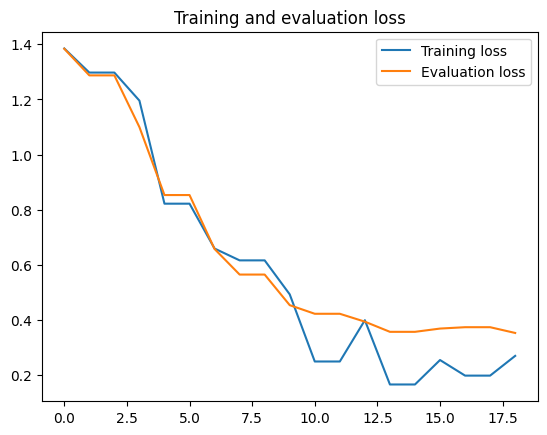

In [19]:
# Training and evaluation loss
train_loss = history['train_loss']
eval_loss = history['eval_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(eval_loss, label='Evaluation loss')
plt.title('Training and evaluation loss')
plt.legend()

* Loss measures the “goodness” of your model

* The smaller the loss, the better the classifier is at modeling the relationship between the input data and the output targets

* But you need to be careful not to overfit

In our case, we stopped training because eval_loss loss did not improve upon the best eval_loss by at least 0.01 for 2 consecutive evaluations.

We can observe fluctuations in the training loss, but overall it is decreasing.
We can have a smoother learning curve by varying hyperparameters, e.g., learning rate, batch size.

In [20]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(dev)
result

0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


{'mcc': np.float64(0.8303458476346232), 'eval_loss': 0.35281137625376385}

* mcc: [ Matthews correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)

* eval_loss: Cross Entropy Loss for dev

Make predictions with the model (predict the labels of the documents in the test set)

In [21]:
predicted, probabilities = model.predict(test.text.to_list())
test['predicted'] = predicted

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Test set predictions

In [22]:
test.head(5)

,text,labels,predicted
0,\nAnd guess who's here in your place.\n\nPleas...,1,1
1,Does anyone know if any of Currier and Ives et...,1,1
2,=FLAME ON\n=\n=Reading through the posts about...,2,2
3,\nBut in this case I said I hoped that BCCI wa...,0,0
4,\nIn the kind I have made I used a Lite sour c...,2,2


Evaluate the model's performance on the test set

In [23]:
# Result (note: your result can be different due to randomness in operations)
print(classification_report(test['labels'], test['predicted']))

              precision    recall  f1-score   support

           0       0.82      0.81      0.81       319
           1       0.82      0.92      0.87       389
           2       0.92      0.87      0.89       396
           3       0.85      0.80      0.83       394

    accuracy                           0.85      1498
   macro avg       0.85      0.85      0.85      1498
weighted avg       0.85      0.85      0.85      1498



### End of this notebook.